# Daymat Gi Ploermel - Scraping + Analysis

Playing with Selenium this time to scrape the <a href='https://smoothcomp.com/en/event/13400'>Smoothcomp page</a> of the Daymat BJJ competition (Ploermel, Nov 2023).

**<a name='0'>Table of contents</a>**

1. <a href='#1'>Importing libraries</a>
2. <a href='#2'>Scrape the participants data ahead of the competition</a>
    * <a href='#21'>2.1. Scraping function</a>
    * <a href='#22'>2.2. Gi data</a>
    * <a href='#23'>2.3. No gi data</a>
    * <a href='#24'>2.4. Build and save dataframe</a>
3. <a href='#3'>Visualisations</a>

## 1. <a name='1'>Importing libraries</a>
(<a href='#0'>Go to top</a>)

In [1]:
import os
import requests
import re
from bs4 import BeautifulSoup
import selenium.webdriver as webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager # conda install -c conda-forge webdriver-manager
from webdriver_manager.firefox import GeckoDriverManager
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

## 2. <a name='2'>Scrape the participants data ahead of the competition</a>
(<a href='#0'>Go to top</a>)

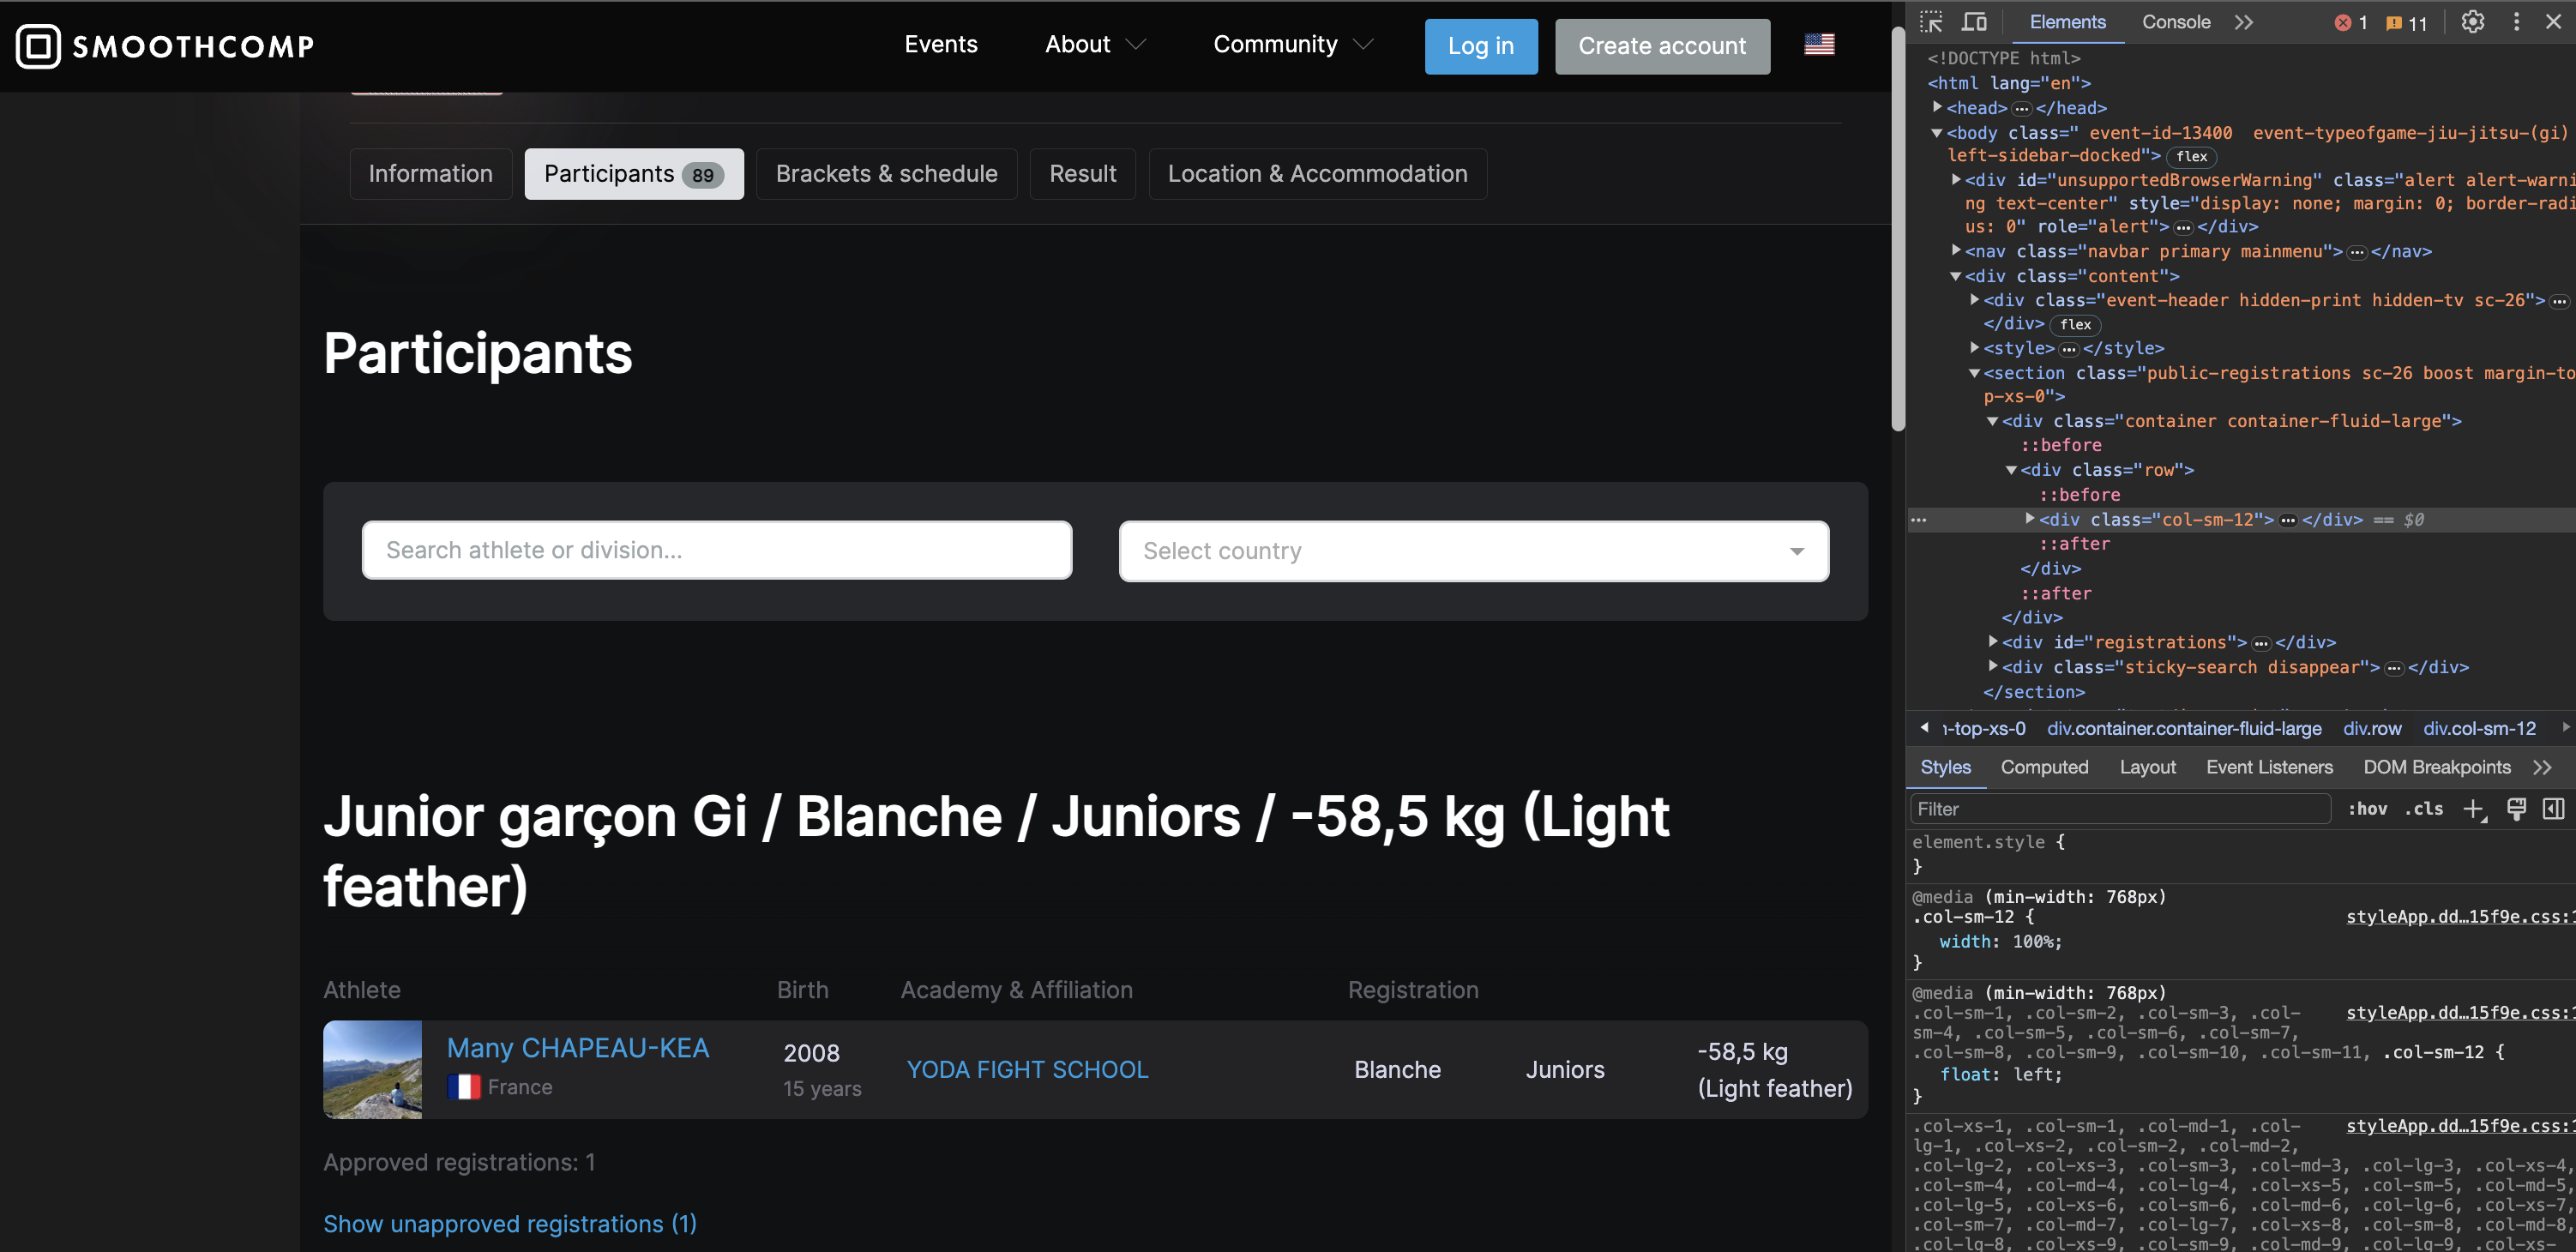

### 2.1. <a name='21'>Scraping function</a>
(<a href='#0'>Go to top</a>)

Looks like the .html I get from BeautifulSoup doesn't match the .html that I can see when I inspect the page. My guess is that requests does not actually run the .js scripts on the page.

In [2]:
url = 'https://smoothcomp.com/en/event/13400/participants'
r = requests.get(url)
soup = BeautifulSoup(r.content, 'html.parser')
print(soup)

<!DOCTYPE html>

<html lang="en">
<head>
<meta charset="utf-8"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<title>
                  Participants - Daymat GI - Smoothcomp
              </title>
<meta content="" name="author"/>
<meta content="IP4toTPfsV1ZLczaf4biLPNKKfdGZnphN9Ye9oGZ" name="csrf-token"/>
<link href="https://smoothcomp.com/en/event/13400/participants" hreflang="en" rel="alternate"/>
<link href="https://smoothcomp.com/pt_BR/event/13400/participants" hreflang="pt_BR" rel="alternate"/>
<link href="https://smoothcomp.com/es/event/13400/participants" hreflang="es" rel="alternate"/>
<link href="https://smoothcomp.com/jp/event/13400/participants" hreflang="jp" rel="alternate"/>
<link href="https://smoothcomp.com/fr/event/13400/participants" hreflang="fr" rel="alternate"/>
<link href="https://smoothcomp.com/it/event/13400/participants" hreflang="it" rel="alternate"/>
<link href="https://smoothcomp.

Let's try selenium. We also need webdriver_manager. Tricky thing here is that you need to scroll the page little by little to reveal the whole page.

In [3]:
def scrape(url):

    driver = webdriver.Firefox(service = Service(GeckoDriverManager().install()))
    driver.maximize_window()
    driver.get(url)

    # to scroll all the way to the bottom of the page as not everything gets loaded from the get go (from: https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python)
    scroll_pause_time = 0.5
    last_height = driver.execute_script('return document.body.scrollHeight') # get scroll height
    while True:
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);') # scroll to bottom
        time.sleep(scroll_pause_time) # wait to load page
        new_height = driver.execute_script('return document.body.scrollHeight') # calculate new scroll height and compare with last scroll height
        if new_height == last_height:
            break
        last_height = new_height

    cat_list = []
    i = 1
    # try to read each category until we have no category left and we get an error
    while True:
        try:
            category = (WebDriverWait(driver, 10)
                        .until(EC.presence_of_element_located((By.XPATH, f'/html/body/div[2]/section/div[2]/div[2]/div[{i}]'))))
            cat_list.append(category.text)
        except:
            break
        i = i + 1
    # release the resources allocated by selenium and shut down the browser
    driver.quit()
    
    return(cat_list)

### 2.2. <a name='22'>Gi data</a>
(<a href='#0'>Go to top</a>)

In [4]:
url = 'https://smoothcomp.com/en/event/13400/participants'
gi_list = scrape(url)

In [5]:
gi_list[0].split('\n')

['Junior garçon Gi / Blanche / Juniors / -58,5 kg (Light feather)',
 'Athlete',
 'Birth',
 'Academy & Affiliation',
 'Registration',
 'Many CHAPEAU-KEA',
 'France',
 '2008',
 '15 years',
 'YODA FIGHT SCHOOL',
 'Blanche',
 'Juniors',
 '-58,5 kg (Light feather)',
 'Alex Clément',
 'France',
 '2007',
 '16 years',
 'MKTEAM RENNES',
 'Blanche',
 'Juniors',
 '-58,5 kg (Light feather)',
 'Approved registrations: 2',
 'Show unapproved registrations (1)']

### 2.3. <a name='23'>No gi data</a>
(<a href='#0'>Go to top</a>)

In [6]:
url = 'https://smoothcomp.com/en/event/13433/participants'
nogi_list = scrape(url)

In [7]:
nogi_list[0].split('\n')

['Junior Garçon No-Gi / Blanche / Junior No Gi / -51,5 kg (Rooster)',
 'Athlete',
 'Birth',
 'Academy & Affiliation',
 'Registration',
 'Lilian Loriot',
 'France',
 '2008',
 '15 years',
 'Monkey gym',
 'Blanche',
 'Junior No Gi',
 '-51,5 kg (Rooster)',
 'Approved registrations: 1']

### 2.4. <a name='24'>Build and save dataframe</a>
(<a href='#0'>Go to top</a>)

In [13]:
def structure_data(cat_list, comp_type):

    df = pd.DataFrame()
    df_dict = {}

    for n in range(len(cat_list)):

        cat_data = cat_list[n].split('\n')
        
        while True:
            try:
                cat_data.remove('certif ok') # adds another line otherwise, need to remove it as many times as it appears
            except ValueError:
                break
                
        while True:
            try:
                cat_data.remove('Ribeiro Jiujitsu') # also adds another annoying line, impact: shorter team name for Respire BJJ
            except ValueError:
                break
        
        fighter_list = []
        country_list = []
        age_list = []
        team_list = []

        cat_name = cat_data[0].lower()
        app_reg_count = int([item for item in cat_data if item.startswith('Approved registrations')][0].split(': ')[- 1])
        try:
            una_reg_count = int([item for item in cat_data if item.startswith('Show unapproved registrations')][0].split('(')[- 1].replace(')', ''))
        except IndexError:
            una_reg_count = 0

        for k in range(app_reg_count):
            fighter_list.append(cat_data[5 + (8 * k)].lower())
            country_list.append(cat_data[6 + (8 * k)].lower())
            age_list.append(int(cat_data[8 + (8 * k)].split(' years')[0]))
            team_list.append(cat_data[9 + (8 * k)].lower())
        df_dict[n] = pd.DataFrame(data = {'nom': fighter_list
                                          , 'pays': country_list
                                          , 'age': age_list
                                          , 'team': team_list
                                         }
                                 )
        
        if 'garçon' in cat_name.split(' / ')[0]:
            gender = 'homme'
        elif 'homme' in cat_name.split(' / ')[0]:
            gender = 'homme'
        else:
            gender = 'femme'
        
        if cat_name.split(' / ')[1].strip() == 'white':
            belt = 'blanche'
        elif cat_name.split(' / ')[1].strip() == 'blue':
            belt = 'bleue'
        elif cat_name.split(' / ')[1].strip() == 'purple':
            belt = 'violette'
        elif cat_name.split(' / ')[1].strip() == 'brown/black':
            belt = 'marron/noire'
        else:
            belt = cat_name.split(' / ')[1].strip()
        
        age_group = cat_name.split(' / ')[2].strip()
        weight_class = cat_name.split(' / ')[3].strip()

        df_dict[n]['sexe'] = gender
        df_dict[n]['ceinture'] = belt
        df_dict[n]['groupe_age'] = age_group
        df_dict[n]['groupe_poids'] = weight_class
        df_dict[n]['categorie'] = cat_name
        df_dict[n]['inscriptions_cate_confirmees'] = app_reg_count
        df_dict[n]['inscriptions_cate_nonconfirmees'] = una_reg_count
        df_dict[n]['type'] = comp_type
        df_dict[n]['snapshot_date'] = pd.to_datetime('today').strftime('%Y-%m-%d')

        df = pd.concat([df, df_dict[n]])
        df.reset_index()

    del df_dict[n]
    
    return(df)

In [14]:
df_gi = structure_data(gi_list, 'gi')
df_nogi = structure_data(nogi_list, 'no gi')
df_fighters = pd.concat([df_gi, df_nogi])
df_fighters.reset_index()
df_fighters = df_fighters[['team'
                           , 'nom'
                           , 'type'
                           , 'pays'
                           , 'age'
                           , 'sexe'
                           , 'ceinture'
                           , 'groupe_age'
                           , 'groupe_poids'
                           , 'inscriptions_cate_confirmees'
                           , 'inscriptions_cate_nonconfirmees'
                           , 'snapshot_date'
                          ]
                         ]
df_fighters.sort_values(by = ['snapshot_date', 'team', 'nom', 'type'], inplace = True)
df_fighters.reset_index(inplace = True, drop = True)
mask = (df_fighters['team'].str.startswith('respire')) | (df_fighters['team'].str.startswith('nostang'))
display(df_fighters[mask])

,team,nom,type,pays,age,sexe,ceinture,groupe_age,groupe_poids,inscriptions_cate_confirmees,inscriptions_cate_nonconfirmees,snapshot_date
130,nostang breizh'il jjb,arthur mengual,gi,france,34.0,homme,bleue,master 1 (30+),"-82,3 kg (middle)",2,0,2023-10-27
131,nostang breizh'il jjb,lucas metivier,gi,france,22.0,homme,blanche,adult,-76 kg (light),16,5,2023-10-27
132,nostang breizh'il jjb,osvaldo l. labrada,no gi,cuba,44.0,homme,blanche,master 3 (41+),"-55,5 kg (rooster)",1,0,2023-10-27
177,respire jiu-jitsu breizh,arnaud eymin,gi,france,34.0,homme,blanche,master 1 (30+),-64 kg (light feather),2,0,2023-10-27
178,respire jiu-jitsu breizh,félicien de boerdère,gi,france,34.0,homme,blanche,master 1 (30+),"-88,3 kg (medium heavy)",3,1,2023-10-27
179,respire jiu-jitsu breizh,félicien de boerdère,no gi,france,34.0,homme,blanche,master 1 (30+),"-85,5 kg (medium heavy)",2,0,2023-10-27
180,respire jiu-jitsu breizh,hugo kermorvant,gi,france,24.0,homme,blanche,adult,-76 kg (light),16,5,2023-10-27
181,respire jiu-jitsu breizh,hugo kermorvant,no gi,france,24.0,homme,blanche,adult,"-79,5 kg (middle)",20,5,2023-10-27
182,respire jiu-jitsu breizh,mehmet yaman,gi,france,31.0,homme,blanche,adult,-76 kg (light),16,5,2023-10-27
183,respire jiu-jitsu breizh,tristan le toux,gi,france,34.0,homme,bleue,adult,-64 kg (light feather),5,0,2023-10-27


Quick checks

In [15]:
df_fighters['team'].value_counts()

zr team rca                               37
yoda fight school                         35
hors normes bjj rennes                    21
mkteam rennes                             19
moka team 443                             14
nbjja bdc                                 12
respire jiu-jitsu breizh                  11
pompomgalli                               11
origine jujitsu                            9
judo plaisir 56                            9
process                                    8
pennarbed jjb                              8
arjjb- bretagne                            7
ohs lutte & grappling                      7
rio de l arrée                             6
icon jiu jitsu team                        6
brazilian sport club                       5
academie pythagore                         4
apc29                                      4
neocortex jiujitsu                         3
nostang breizh'il jjb                      3
gant hermine vannetais                     3
associatio

In [16]:
df_fighters['groupe_poids'].value_counts()

-70 kg (feather)            32
-79,5 kg (middle)           25
-67,5 kg (feather)          24
-76 kg (light)              23
-73,5 kg (light)            22
-82,3 kg (middle)           17
-64 kg (light feather)      14
-85,5 kg (medium heavy)     12
-61,5 kg (light feather)    11
-94,3 kg (heavy)            10
-88,3 kg (medium heavy)     10
-97,5 kg (super heavy)       6
-100,5 kg (super heavy)      5
-91,5 kg (heavy)             5
-61,5 kg (feather)           4
-71,5 kg (middle)            4
-74,0 kg (middle)            4
-57,5 kg (rooster)           4
-66,5 kg (light)             4
+100,5 kg (ultra heavy)      3
-64,0 kg (feather)           3
-55,5 kg (rooster)           3
-56,5 kg (feather)           3
+97,5 kg (ultra heavy)       3
-66,5 kg (middle)            2
-58,5 kg (light feather)     2
-69,0 kg (light)             2
-56,5 kg (light)             1
-54,5 kg (light)             1
-66,5 kg (heavy)             1
-69 kg (heavy)               1
+79,3 kg (super heavy)       1
-65,0 kg

In [17]:
df_fighters['ceinture'].value_counts()

blanche         179
bleue            65
violette         13
marron/noire     11
Name: ceinture, dtype: int64

Fetch the saved .csv if you want to:

In [18]:
need_import = input('Do you want to import an existing dataframe? (y/n)')

if need_import == 'y':
    df_fighters_import = pd.read_csv('df_fighters.csv')
else:
    df_fighters_import = pd.DataFrame()

Do you want to import an existing dataframe? (y/n)y


In [19]:
display(df_fighters_import.sample(3))

,team,nom,type,pays,age,sexe,ceinture,groupe_age,groupe_poids,inscriptions_cate_confirmees,inscriptions_cate_nonconfirmees,snapshot_date
149,pompomgalli,lucsuworna hellard,gi,france,28.0,homme,bleue,adult,-64 kg (light feather),5,0,2023-10-26
74,mkteam rennes,antoine gautrain,gi,france,26.0,homme,bleue,adult,-70 kg (feather),7,2,2023-10-26
586,pennarbed jjb,anatole isch,no gi,france,28.0,homme,NaN,NaN,NaN,1,0,2023-10-24


Concatenate with the newly collected data and check we have the right dates:

In [24]:
df_fighters_new = pd.concat([df_fighters, df_fighters_import])
df_fighters_new.reset_index(inplace = True, drop = True)
display(df_fighters_new
        .groupby('snapshot_date', as_index = False)
        .agg({'nom': 'nunique'})
        .rename(columns = {'nom': 'participants'})
        .sort_values(by = 'snapshot_date'))

,snapshot_date,participants
0,2023-10-24,161
1,2023-10-25,176
2,2023-10-26,194
3,2023-10-27,212


Overwrite the .csv with the new data:

In [25]:
df_fighters = df_fighters_new.copy()
df_fighters.to_csv('df_fighters.csv', index = False)

## 3. <a name='3'>Visualisations</a>
(<a href='#0'>Go to top</a>)

In [44]:
df = (df_fighters
      .groupby(['team', 'snapshot_date'], as_index = False)
      .agg({'nom': 'nunique'})
      .rename(columns = {'nom': 'participants_confirmes', 'snapshot_date': ' '})
      .pivot(index = 'team', columns = ' ', values = 'participants_confirmes')
      .fillna(0))

latest_date = max(df.columns)
df.sort_values(by = latest_date, ascending = False, inplace = True)
print(f'\nNombre de participants confirmés par équipe au {latest_date}:')
df = df.astype('int')
display(df)


Nombre de participants confirmés par équipe au 2023-10-27:


,2023-10-24,2023-10-25,2023-10-26,2023-10-27
team,,,,
zr team rca,22,25,28,31
yoda fight school,20,24,26,26
hors normes bjj rennes,12,14,16,17
mkteam rennes,10,13,15,17
nbjja bdc,12,12,12,12
moka team 443,11,12,11,12
respire jiu-jitsu breizh,4,4,6,7
pompomgalli,6,6,8,7
pennarbed jjb,8,8,7,7


store url behind each name